In [1]:
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import keras_tuner as kt

In [2]:
master_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/trashnet/dataset-resized',
    labels='inferred',
    image_size=(512, 256),
    batch_size=32,
    shuffle=True
)

Found 2527 files belonging to 6 classes.


In [3]:
class_names = master_dataset.class_names

In [4]:
def load_class_dataset(master_dataset, class_index, augment=False, num_samples=None):
    dataset = (master_dataset.unbatch()).filter(lambda x, y: tf.equal(y, class_index))

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"), # apply augmentation only if we have to make more images
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.1)
        ])
        dataset = dataset.map(lambda x, y: (aug(x, training=True), y))

    if num_samples is not None:
        dataset = dataset.shuffle(buffer_size=num_samples, seed=123).repeat().take(num_samples)
    return dataset.batch(32)

In [5]:
batched_dataset = []
counts = [403, 501, 482, 594, 410, 137]
target_size = 400

for i, count in enumerate(counts):
    # need to cut out some of the images
    batched_dataset.append(load_class_dataset(master_dataset, i, count < target_size, target_size))

balanced_dataset = batched_dataset[0]
for dataset in batched_dataset[1:]:
    balanced_dataset = balanced_dataset.concatenate(dataset)

In [6]:
total_samples = target_size * len(class_names)
shuffled = balanced_dataset.unbatch().shuffle(total_samples, seed=123)

In [7]:
train_dataset = (
    shuffled.take(int(0.7 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    shuffled.skip(int(0.7 * total_samples)).take(int(0.2 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    shuffled.skip(int(0.9 * total_samples)).take(int(0.1 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

In [8]:
def model_builder(hyperparameter):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=(512, 256, 3)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())

    hyperparameter_units = hyperparameter.Int('units', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hyperparameter_units, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names)))

    hyperparameter_learning_rate = hyperparameter.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameter_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [9]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory='my_dir5',
                     project_name='intro_to_kt5')

/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
tuner.search(train_dataset, epochs=50, validation_data=validation_dataset)

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hyperparameters.get('units')} and the optimal learning rate for the optimizer
is {best_hyperparameters.get('learning_rate')}.
""")

Trial 30 Complete [00h 04m 35s]
val_accuracy: 0.7729166746139526

Best val_accuracy So Far: 0.7895833253860474
Total elapsed time: 00h 52m 47s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.001.



In [11]:
model = tuner.hypermodel.build(best_hyperparameters)
fitted_model = model.fit(train_dataset, validation_data=validation_dataset, epochs=50)

val_acc_per_epoch = fitted_model.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step - accuracy: 0.1856 - loss: 3.4558 - val_accuracy: 0.3812 - val_loss: 1.5388
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 444ms/step - accuracy: 0.4388 - loss: 1.4169 - val_accuracy: 0.5375 - val_loss: 1.2488
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.5878 - loss: 1.1563 - val_accuracy: 0.6083 - val_loss: 1.0292
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - accuracy: 0.6475 - loss: 0.9552 - val_accuracy: 0.5771 - val_loss: 1.1251
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 488ms/step - accuracy: 0.7327 - loss: 0.7603 - val_accuracy: 0.5208 - val_loss: 1.4909
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 465ms/step - accuracy: 0.7375 - loss: 0.7185 - val_accuracy: 0.6479 - val_loss: 1.1528
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 489ms/step - accuracy: 0.7977 - loss: 0.5662 - val_accuracy: 0.6729 - val_loss: 1.1626
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 478ms/step - accuracy: 0.8208 - loss: 0.5003 - val_accu

2025-06-08 20:55:18.436411: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 447ms/step - accuracy: 0.8631 - loss: 0.4192 - val_accuracy: 0.7229 - val_loss: 1.2292
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 0.9092 - loss: 0.2731 - val_accuracy: 0.7500 - val_loss: 1.3025
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 437ms/step - accuracy: 0.9293 - loss: 0.2317 - val_accuracy: 0.7542 - val_loss: 1.2838
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - accuracy: 0.9622 - loss: 0.1236 - val_accuracy: 0.7646 - val_loss: 1.3377
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - accuracy: 0.9674 - loss: 0.0940 - val_accuracy: 0.7792 - val_loss: 1.3074
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - accuracy: 0.9820 - loss: 0.0619 - val_accuracy: 0.7250 - val_loss: 1.8111
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.9693 - loss: 0.0992 - val_accuracy: 0.7771 - val_loss: 1.4050
Epoch 16/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 431ms/step - accuracy: 0.9823 - loss: 0.0693 - val_accuracy

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 512, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 510, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 255, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 253, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 126, 62, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 124, 60, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 119040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    30,474,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,514,036 (349.10 MB)

 Trainable params: 30,504,678 (116.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,009,358 (232.73 MB)

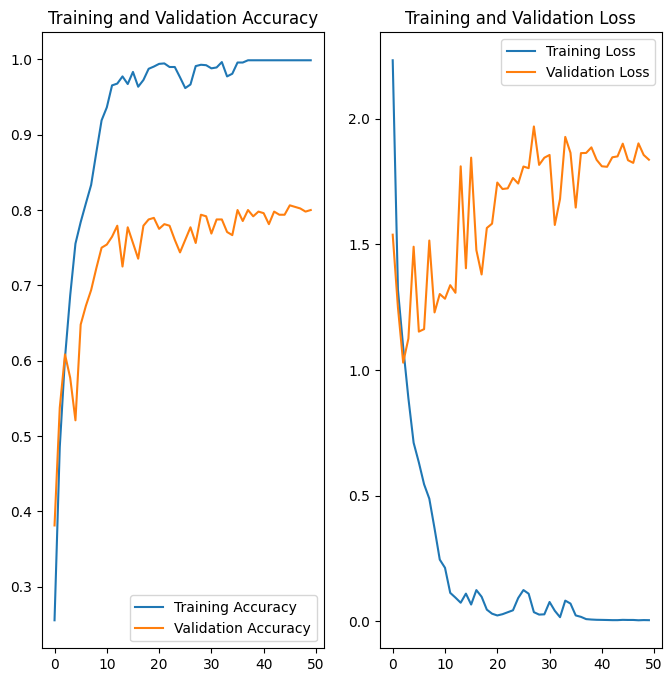

In [13]:
acc = fitted_model.history['accuracy']
val_acc = fitted_model.history['val_accuracy']

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

fitted_hypermodel = hypermodel.fit(train_dataset, validation_data=validation_dataset, epochs=7) # higher epochs that is found as "best" is not proving to be the best

Epoch 1/7


/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     53/Unknown 25s 453ms/step - accuracy: 0.2148 - loss: 2.4378

/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 491ms/step - accuracy: 0.2164 - loss: 2.4263 - val_accuracy: 0.5083 - val_loss: 1.3079
Epoch 2/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 474ms/step - accuracy: 0.5142 - loss: 1.2856 - val_accuracy: 0.5938 - val_loss: 1.1937
Epoch 3/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.6303 - loss: 1.0548 - val_accuracy: 0.6667 - val_loss: 1.0094
Epoch 4/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 499ms/step - accuracy: 0.7223 - loss: 0.8042 - val_accuracy: 0.7042 - val_loss: 0.9640
Epoch 5/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - accuracy: 0.8047 - loss: 0.5740 - val_accuracy: 0.7146 - val_loss: 0.9220
Epoch 6/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.8652 - loss: 0.4364 - val_accuracy: 0.7250 - val_loss: 0.9731
Epoch 7/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 474ms/step - accuracy: 0.8557 - loss: 0.4313 - val_accuracy: 0.7437 - val_loss: 0.9699


In [32]:
hypermodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 512, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 510, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 255, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 253, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 126, 62, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 124, 60, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 119040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    30,474,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,514,036 (349.10 MB)

 Trainable params: 30,504,678 (116.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,009,358 (232.73 MB)

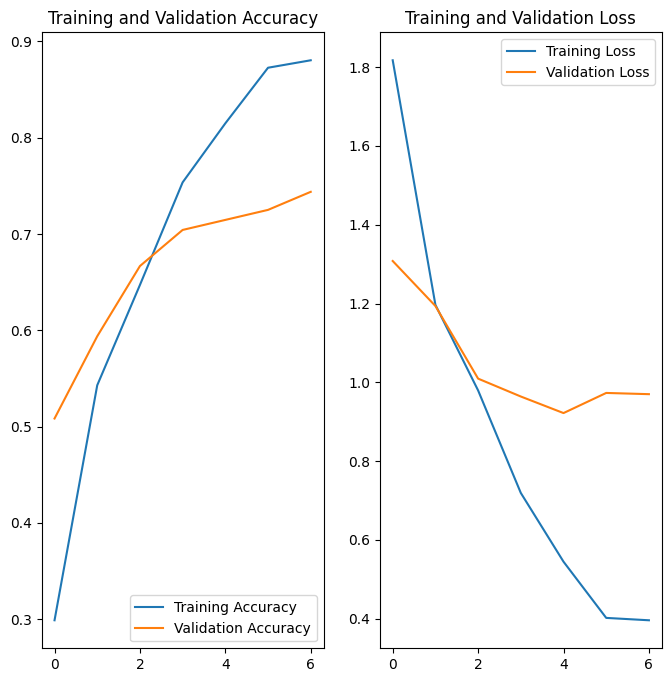

In [34]:
acc = fitted_hypermodel.history['accuracy']
val_acc = fitted_hypermodel.history['val_accuracy']

loss = fitted_hypermodel.history['loss']
val_loss = fitted_hypermodel.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
eval_result = model.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.8109 - loss: 1.7106
[test loss, test accuracy]: [1.735796332359314, 0.8083333373069763]


In [36]:
img = Image.open('../data/test/cardboard_test.jpeg').resize((512, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to cardboard with a 100.00 percent confidence.
[1.0000000e+00 5.3357072e-11 5.9421898e-15 1.4722895e-21 8.6269676e-09
 4.1875559e-08]


In [37]:
best_model = tuner.get_best_models(1)[0]

/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
tuner.get_best_hyperparameters()

In [38]:
eval_result = best_model.evaluate(test_dataset) # accuracy may be lower but loss is better
print("[test loss, test accuracy]:", eval_result)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7494 - loss: 1.0171
[test loss, test accuracy]: [0.9798325896263123, 0.7833333611488342]


In [39]:
img = Image.open('../data/test/cardboard_test.jpeg').resize((512, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = best_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
This image most likely belongs to cardboard with a 99.99 percent confidence.
[9.9993479e-01 8.3757513e-08 6.5038073e-09 5.2049511e-11 2.9533032e-06
 6.2179264e-05]


In [40]:
best_model.save(filepath='../models/best_model.keras')

In [49]:
best_model.export("model_dir")

INFO:tensorflow:Assets written to: model_dir/assets


INFO:tensorflow:Assets written to: model_dir/assets


Saved artifact at 'model_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  14755981904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13021529872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14755980944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14755981712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14755983440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13502569488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13502578128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13502576784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13502578512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13502576400: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [52]:
import tarfile
with tarfile.open("model.tar.gz", "w:gz") as tar:
    tar.add("../model_dir", arcname=".")